<a href="https://colab.research.google.com/github/hmerkle/IANNWTF_Group_14_Submissions/blob/master/Image_colorization_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **What is image colorization?** 

Image colorization aims to convert black and white images to a realistic colorful images. This is a challenging task as there are many possibles color values which can be assigned to the same luminace. 

In our project we use the COCO dataset. As the whole dataset is too big for our use, we only worked with the validation set with 5000 colorful images.

To realize the task, we built a Genertive Adversarial Network (GAN) including a Generator which is structured as a U-Net and a Discriminator. 
In the process we convert the RGB images into Lab colorspace. The L-channel is used as the input for the Generator which generates the a and b color channels. The Discriminator receives the real and generated a and b color channels and decides on their truth value. The l and ab color channels are concatenated to receive the complete Lab image.

The challenge is to find the equilibrium between to generator and discriminator loss to create realistic colorful images.

## **Why is image colorization necessary?**

The process of automated image colorization has become essential in many different fields.
Due to photographic limitations from the past and present, many images and videos exist in monochrome or unrealistic colorization. This includes old pictures and video recordings, electron microscopic images, infrared images, radar images, and many more.

All these images can be made more accessible and vivid through image colorization and also manipulated to reduce differences between images for further processing.
Image colorization is therefore important not only in the creative field but also in science and many of our daily life applications.

In the past, colorization was done manually making it a tedious and time-consuming task. Therefore, machine and deep learning methods have been proposed and developed to automate this expensive task making use of convolutional neural networks. 

[Linktext](https://www.researchgate.net/publication/341795637_Automatic_gray_images_colorization_based_on_lab_color_space)

#Imports

In [ ]:
import os
import zipfile

import random
import matplotlib.pyplot as plt
import numpy as np

import PIL
import urllib
from IPython import display
from skimage import io, color
import cv2

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPool2D, Conv2DTranspose, Reshape, Activation, BatchNormalization, GlobalAvgPool2D, LeakyReLU, Concatenate, ReLU
from keras.initializers import RandomNormal

# Import data

For our task we use the COCO (Common Objects in Context) dataset. Even though this dataset is designed for computer vision tasks like object detection and segmentation we regarded its big amount of different categories and its every day scenes as fitting for the colorization task. Due to hardware and time limitations we only used the 2017 COCO validation set. It comes with 5000 different colorful images.

In [ ]:
# Set to true if dataset needed
download_dataset = True

if download_dataset == True:
  # !wget http://images.cocodataset.org/zips/train2017.zip # 18G, 118287 images
  !wget http://images.cocodataset.org/zips/val2017.zip # 778MB, 5000 images

  # unzip the file and extract contents into '/temp' folder
  with zipfile.ZipFile('val2017.zip','r') as zip:     # ZipFile constructor; READ mode
      zip.extractall('/tmp')                          # Extract contents to tmp 

# define path to dataset
path = '/tmp/val2017/'

print("Dataset Length: ", len(os.listdir(path)))

Dataset Length:  5000


In the following the images are read from the /temp path. 

We convert them to RGB first, resize to our predefined image size and finally convert them to Lab.

In [ ]:
# initialize arrays for different color channels
data_lab = []
data_l = []
data_ab = []

# image size
IMG_SIZE = 256
count = 0

# convert images to lab and fill arrays with images
for img in os.listdir(path):
  if count < 2000:
    bgr_img = cv2.imread(os.path.join(path, img))
    # CV read uses BGR -> convertion to RGB necessary by inverting images
    rgb_img = np.flip(bgr_img, axis=-1) 
    # resize images
    rgb_img = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
    # convert rgb to lab
    lab_img = color.rgb2lab(rgb_img)
    # create lab dataset for visualization
    data_lab.append(lab_img) #(0-100),(-128-127),(-128-127)
    # create l dataset and respape from (IMG_SIZE, IMG_SIZE) to (IMG_SIZE, IMG_SIZE, 1) to avoid later issues
    data_l.append(np.reshape(lab_img[:, :, 0], (IMG_SIZE, IMG_SIZE, 1)))
    # create ab dataset
    data_ab.append(lab_img[:, :, 1:])
    count += 1


print("Number of images: ", len(data_lab))
print("Size images: ", len(data_lab[0]))

Number of images:  5
Size images:  256


# Visualize 'Lab' color space

An image usually consits of a rank-3 array with the first and second axis including its height and width and the last axis the color information.

**RGB**

The third axis of an RGB image has a dimension of three. In the RGB color space each pixel has a red, a green and a blue color channel. All three add together to a united color and therefore realistic colorful image.

**Lab**

Like in RGB, the Lab colorspace also consits of three channels but with a different composition. The first channel is the L-channels which is relevant for the lightness of the image. It only contains the contrast between the darkest and lightest spots in an image. The a-channel contains a color spectrum between green and red and the b-channel contains a spectrum between blue and yellow. 

For our colorization task we use the L * a * b color space. In contrast to RGB where three color color channels would need to be predicted, we only need to predict two. The L-channel is used as an input for the Generator. Therefore the generator only needs to predict the a and b channels. As a result we can receive more stable results as there are less combinations possible. 

[Linktext](https://fairyonice.github.io/Color-space-defenitions-in-python-RGB-and-LAB.html), [Linktext](http://shutha.org/node/851)

For illustration purpose the three L * a * b  channels are visualized.

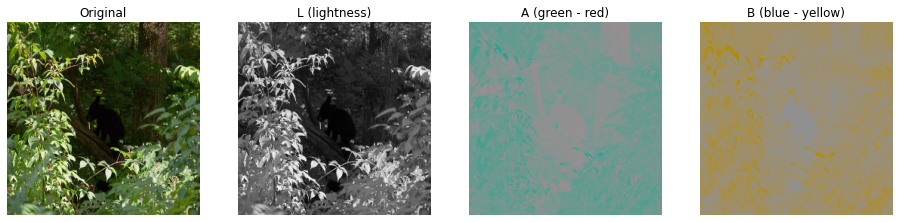

In [ ]:
# Choose a random image from the dataset to illustrate L*a*b color space
idx = random.randrange(len(data_lab))
lab_img = data_lab[idx]

fig = plt.figure(figsize=(20,10))

# Plot original image and 3 channels
for i, title in enumerate(["Original", "L (lightness)","A (green - red)","B (blue - yellow)"]):
    channel = i - 1

    if title == "Original":
      temp = lab_img
    else:
      temp = np.zeros(lab_img.shape)
      # increase brightness for a and b colorspace for better visability
      if channel != 0:
          temp[:,:,0] = 60
      temp[:,:,channel] = lab_img[:,:,channel]

    ax = fig.add_subplot(1,5,i+1)
    ax.imshow(color.lab2rgb(temp)); ax.axis("off")
    ax.set_title(title)

plt.show()

In [ ]:
# x = 1
# min  = 100
# for i in data_lab:
#   #print(i[:, :, 0])
#   min_temp = np.amin(i[:, :, 0])
#   if min_temp < min:
#     min = min_temp

#print(min)
# 0 : min:0, max:100
# 1 : min: -82.9, max:97.4 
# 2 : min: -107.2, max:94.5 

# Prepare data

### Input pipeline

The values of the images need to be converted from integer to float. 

Then the values are normalized into a range between -1 and 1.
In the Lab color space, the L channel usually includes values from 0 to 100 and the a and b channels from +128 to -128. 
In our dataset the a and b channel values are in a range between approximately -110 and +100. For normalization we therefore devide them by 110. instead of 128..

After the normalization the data is shuffled, batched and prefetched.

In [ ]:
# Description:Input pipeline to prepare dataset
#             Inputs: images, batch size
#             Outputs: prepared images
def prepare(data, batch_size):
    # convert datatype to float32
    data = data.map(lambda l_img, ab_img: (tf.cast(l_img, tf.float32), tf.cast(ab_img, tf.float32)))
    
    # normalize image pixels to range ~[-1, 1]
    data = data.map(lambda l_img, ab_img: ((l_img/50.-1.), (ab_img/110.)))
      
    #shuffle, batch, prefetch
    data = data.shuffle(100).batch(batch_size).prefetch(batch_size*4)
      
    #return preprocessed dataset
    return data

### Split data

In [ ]:
# define a split ratio for the train data
ratio_train = 0.8
train_len = round(len(data_l)*ratio_train)

# create arrays for test and train images for l and ab channels
l_train_images = data_l[:train_len]
l_test_images = data_l[train_len:]

ab_train_images = data_ab[:train_len]
ab_test_images = data_ab[train_len:]

print("Length train data: ", len(l_train_images))
print("Length test data: ", len(l_test_images))

Length train data:  4
Length test data:  1


### Create tensor datasets

In [ ]:
batch_size = 10

# Create tensorflow datasets for the training and test data.
train_tensors = tf.data.Dataset.from_tensor_slices((l_train_images, ab_train_images))
test_tensors = tf.data.Dataset.from_tensor_slices((l_test_images, ab_test_images))

# Prepare the images
train_ds = prepare(train_tensors, batch_size)
test_ds = prepare(test_tensors, batch_size)

# The Generator

The generator is based on a U-Net structure. It has an encoder–decoder structure. In the U-Net the images are first downsampled until a bottleneck layer is reached and the upsampled again until they reached the desired output size. Important in a U-Net is that skip connections are used where the outputs of the downsampling process are concatened with the outputs of the Upsampling process. The idea behind this is that due to this, low-level information is kept which would have been lost at the bottleneck layer.

The Generator will receive the L-channel witch the shape (batch, 256, 256, 1) as an input and generate the ab-channel with shape ( batch, 256, 256, 2) as an output.

The Down- and Upsampling are made up of each 5 convolutional blocks. The encoder uses the LeakyReLu as an activation function to avoid vanishing gadients whereas in the decoder ReLu is used and a dropout to avoid overfitting
and add diversity to the generated images.

For the output layer the Tanh activation function is used to get the correct pixel values.

[Linktext](file:///C:/Users/hanna/Downloads/sensors-22-01599-v2.pdf)

###Downsampling -> Encoder

In [ ]:
class Downsampler(tf.keras.Model):

    """Creating Downsampling layers
    
    3 convolutional layers each followed by a batch normalizationa dn Leaky Relu activation function to avoid vanishing gradients.

    Class receives input from Generator.
    
    """ 

    def __init__(self, depth):
        super(Downsampler, self).__init__()

        self.depth = depth
        init = RandomNormal(mean=0.0, stddev=0.02) # Initializer generating tensors with normal distribution
     
        self.conv_1 = Conv2D(filters=depth/2, kernel_size=4, strides=1, padding='same', kernel_regularizer = init)
        self.batchnorm_1 = BatchNormalization()
        self.act_1 = LeakyReLU(alpha=0.2)
        
        self.conv_2 = Conv2D(filters=depth, kernel_size=4, strides=1, padding='same', kernel_regularizer = init)
        self.batchnorm_2 = BatchNormalization()
        self.act_2 = LeakyReLU(alpha=0.2)
        
        self.conv_3 = Conv2D(filters=depth, kernel_size=4, strides=2, padding='same', kernel_regularizer = init)
        self.batchnorm_3 = BatchNormalization()
        self.act_3 = LeakyReLU(alpha=0.2)
        
        
    @tf.function
    def call(self, inputs):
            
        x = self.conv_1(inputs)
        x = self.batchnorm_1(x)
        x = self.act_1(x)
        
        x = self.conv_2(x)
        x = self.batchnorm_2(x)
        x = self.act_2(x)
            
        x = self.conv_3(x)
        x = self.batchnorm_3(x)
        x = self.act_3(x)

        return x

### Upsampling -> Encoder

In [ ]:
class Upsampler(tf.keras.Model):

    """Creating Upsampling layers
    
    1 convolutional layers and 1 convolutional transpsitioning layer for upsampling the input.
    Each followed by a batch normalization, Dropout and Relu activation.

    Class receives input from Generator.
    
    """ 

    def __init__(self, depth, drop):
        super(Upsampler, self).__init__()

        self.depth = depth
        self.drop = drop
        init = RandomNormal(mean=0.0, stddev=0.02) # Initializer generating tensors with normal distribution

        self.conv_1 = Conv2D(filters=depth, kernel_size=4, strides=1, padding='same', kernel_regularizer = init)
        self.batchnorm_1 = BatchNormalization()
        self.dropout_1 = Dropout(drop)
        self.act_1 = tf.keras.layers.ReLU()

        self.tconv_1 = Conv2DTranspose(filters=depth, kernel_size=4, strides=2, padding='same', kernel_regularizer = init)
        self.batchnorm_2 = BatchNormalization()
        self.dropout_2 = Dropout(drop)
        self.act_2 = tf.keras.layers.ReLU()
    
        
    @tf.function
    def call(self, inputs, training):

        x = self.conv_1(inputs)
        x = self.batchnorm_1(x)

        if training == True:
            x = self.dropout_1(x)

        x = self.act_1(x)


        x = self.tconv_1(x)
        x = self.batchnorm_2(x)

        if training == True:
            x = self.dropout_2(x)

        x = self.act_2(x)
        
        return x

## Generator -> Encoder-Decoder structure

Remember:
*Change made to the generator -> update kernel size from 5 to 4 to avoid reducing checkerboard artifacts in the generated images.*

*Reason: kernel size of 5 is not divisible by the stride of 2, according to the post Deconvolution and Checkerboard Artifacts.*

[Linktext](https://pyimagesearch.com/2021/12/13/gan-training-challenges-dcgan-for-color-images/)

In [ ]:
class Generator(tf.keras.Model):

    """Generator class
    
    Generator with U-Net structure.
    Instantiates Downsampling and Upsampling layers and concatenates outputs.
    Through the concatenations low-level information are preserved.
    Output is passed through a convolutional layer with filter size of 2 and tanh as an activation function.

    Class receives L channel as input with shape (batch, 256, 256, 1).
    Generates ab-channel with shape (batch, 256, 256, 2)
    
    """ 
    
    def __init__(self, depth, drop_up):
        super(Generator, self).__init__()

        self.depth = depth
        self.drop_up = drop_up

        self.down_0 = Downsampler(depth/2)    #filt=32
        self.down_1 = Downsampler(depth)    #filt=64
        self.down_2 = Downsampler(depth*2)  #128
        self.down_3 = Downsampler(depth*4)  #256
        self.down_4 = Downsampler(depth*8)  #512
        #self.down_5 = Downsampler(depth*16) #1024

        # self.up_1 = Upsampler(depth*8, drop_up)
        # self.concat_1 = Concatenate()
        # self.up_2 = Upsampler(depth*4, drop_up)
        # self.concat_2 = Concatenate()
        # self.up_3 = Upsampler(depth*2, drop_up)
        # self.concat_3 = Concatenate()
        # self.up_4 = Upsampler(depth, drop_up)
        # self.concat_4 = Concatenate()
        # self.up_5 = Upsampler(depth/2, drop_up)

        #test
        self.up_1 = Upsampler(depth*4, drop_up)
        self.concat_1 = Concatenate()
        self.up_2 = Upsampler(depth*2, drop_up)
        self.concat_2 = Concatenate()
        self.up_3 = Upsampler(depth*1, drop_up)
        self.concat_3 = Concatenate()
        self.up_4 = Upsampler(depth/2, drop_up)
        self.concat_4 = Concatenate()
        self.up_5 = Upsampler(depth/4, drop_up)
        #test

        self.color = Conv2D(filters = 2, kernel_size = 2, strides = 1, padding='same', activation='tanh')
 

    @tf.function
    def call(self, inputs, training): #128, 128, 1
        #downsampling
        #print("gen_inp: ", inputs.shape)
        # x1 = self.down_1(inputs)   # 64, 64, 64
        # x2 = self.down_2(x1)       # 32,32,128
        # x3 = self.down_3(x2)       # 16,16,256
        # x4 = self.down_4(x3)       # 8, 8, 512
        # x5 = self.down_5(x4)       # 4, 4, 1024
        
        #test
        x1 = self.down_0(inputs)   # 64, 64, 64
        # print("x1", x1.shape)
        x2 = self.down_1(x1) 
        # print("x2", x2.shape)
        x3 = self.down_2(x2)       # 32,32,128
        # print("x3", x3.shape)
        x4 = self.down_3(x3)       # 16,16,256
        # print("x4", x4.shape)
        x5 = self.down_4(x4)       # 8, 8, 512
        # print("x5", x5.shape)
        #test

        #upsampling
        x6 = self.up_1(x5, training)     # 8, 8, 512
        # print("x6", x6.shape)

        x7 = self.concat_1([x4, x6])     # 8, 8, 1024
        # print("x7", x7.shape)
       
        x8 = self.up_2(x7, training)     # 16, 16, 256
        # print("x8", x8.shape)
        x9 = self.concat_2([x3, x8])     # 16, 16, 512
        # print("x9", x9.shape)

        x10 = self.up_3(x9, training)    # 32, 32, 128
        # print("x10", x10.shape)
        x11 = self.concat_3([x2, x10])   # 32, 32, 256
        # print("x11", x11.shape)
        
        x12 = self.up_4(x11, training)   # 64, 64, 64
        # print("x12", x12.shape)
        x13 = self.concat_4([x1, x12])   # 64, 64, 128
        # print("x13", x13.shape)
        
        x14 = self.up_5(x13, training)   # 128, 128, 32
        # print("x14", x14.shape)

        out = self.color(x14)            # 128,128,2
        # print("out", out.shape)
        # print("Gen_out:", out.shape)
        
        return out

    # def model(self):
    #     x = tf.keras.Input(shape=(256, 256, 1))
    #     return Model(inputs=[x], outputs=self.call(x, False))

In [ ]:
# from tensorflow.keras import Model
# # commen tf.function
# generator = Generator(64, 0.5)
# generator.model().summary()

# The Discriminator

[Linktext](https://www.tensorflow.org/tutorials/generative/pix2pix
)

### Discriminate class for downsampling

In [ ]:
class Discriminate(tf.keras.Model):

    """Downsampling for Discriminator
  
    Convolutional layer followed by a batch normalizationa, Dopout and Leaky Relu activation function.

    Receives input from Discriminator.
    Returns downsampled input.
    
    """ 

    def __init__(self, depth, drop):
        super(Discriminate, self).__init__()

        self.depth = depth
        self.drop = drop
        init = RandomNormal(mean=0.0, stddev=0.02) # Initializer generating tensors with normal distribution

        self.conv = Conv2D(filters=depth, kernel_size=4, strides=2, padding='same', kernel_regularizer = init)
        self.batchnorm = BatchNormalization()
        self.dropout = Dropout(drop)
        self.act = LeakyReLU(alpha=0.2)

    @tf.function
    def call(self, inputs, training):
        x = self.conv(inputs)
        x = self.batchnorm(x)
        if training == True:
          x = self.dropout(x)
        x = self.act(x)
        return x

In [ ]:
class Discriminator(tf.keras.Model):

    """Discriminator class
  
    Convolutional layers followed by a flattening layer and several dense layers to receive desired output size.
    last layer with sigmoid activation function.

    Receives real and generated ab-channels with shape (batch, 256, 256, 2).
    Returns one number as output to discriminate real from fake input with shape (batch, 1).
    
    """ 

    def __init__(self, depth, drop):
        super(Discriminator, self).__init__()

        self.depth = depth
        self.drop = drop
        init = RandomNormal(mean=0.0, stddev=0.02) # Initializer generating tensors with normal distribution

        # Input: 256x256x2

        self.conv_1 = Conv2D(filters = 1*depth, kernel_size = 4, strides = 2, padding = 'same', activation=LeakyReLU(alpha=0.2), input_shape=(256, 256, 2)) #128x128x32

        self.dropout_1 = Dropout(drop) 

        self.discr_1 = Discriminate(2*depth, drop)
        self.discr_2 = Discriminate(4*depth, drop)
        self.discr_3 = Discriminate(8*depth, drop)
        self.discr_4 = Discriminate(16*depth, drop)
        #self.discr_5 = Discriminate(32*depth, drop) # depth 32 and depth 1024 drop=0.4
        
        self.flatten = Flatten()
        
        self.dense_0 = Dense(512, activation="relu")
        #self.dense_1 = Dense(256, activation="relu")

        self.dropout_2 = Dropout(drop)

        self.dense_2 = Dense(128, activation="relu")
        self.dense_3 = Dense(16, activation="relu")
        self.dense_4 = Dense(1, activation="sigmoid")


    @tf.function
    def call(self, inputs, training):

        x = self.conv_1(inputs)
        #print(x.shape)
        
        if training == True:
            x = self.dropout_1(x)

        x = self.discr_1(x)
        #print(x.shape)
        x = self.discr_2(x)
        #print(x.shape)
        x = self.discr_3(x)
        #print(x.shape)
        x = self.discr_4(x)
        #print(x.shape)
        # x = self.discr_5(x)
        # print(x.shape)

        x = self.flatten(x)
        #print(x.shape)
        
        x = self.dense_0(x)
        #print(x.shape)
        #x = self.dense_1(x)
        #print(x.shape)

        if training == True:
            x = self.dropout_2(x)
            
        x = self.dense_2(x)
        #print(x.shape)
        x = self.dense_3(x)
        #print(x.shape)
        x = self.dense_4(x)
        #print(x.shape)
        #print("Discr_out: ", x.shape)
        return x

    # def model(self):
    #    x = tf.keras.Input(shape=(256, 256, 2))
    #    return Model(inputs=[x], outputs=self.call(x, False))

In [ ]:
# from tensorflow.keras import Model
# # commen tf.function
# discriminator = Discriminator(64, 0.5)
# discriminator.model().summary()

# Losses

###Discriminator Loss
The loss function is sum of the binary cross entropy on the class of the real samples (label 1) and the binary cross entropy on the class of the generated samples (label 0).

In [ ]:
# loss of  discriminator is based on how well the discriminator detected fake images as fake and real images as real
def get_discriminator_loss(bce_loss, real_prediction, fake_prediction):
  
    # compute BCE between discriminators output on real images and all labels = 1
    real_loss = bce_loss(real_prediction, tf.ones_like(real_prediction)) # - tf.random.uniform(shape=real_prediction.shape, maxval=0.1)
    #print("real_loss: ", real_loss)
    # compute BCE between  discriminators output on fake images and all labels=0
    fake_loss = bce_loss(fake_prediction, tf.zeros_like(fake_prediction)) #  + tf.random.uniform(shape=fake_prediction.shape, maxval=0.1)
    #print("fake_loss: ", fake_loss)

    #Add them both to receive the resulting loss of the discriminator
    total_loss = real_loss + fake_loss
    
    return total_loss

###Generator Loss

use of L1 loss in addition the the binary cross entropy loss for the Generator to receive output images which are more similar to the realistic images.

-> use for training only?

In [ ]:
# loss of generator is estimated by how well the generator was able to fool the discriminator
def get_generator_loss(bce_loss, fake_prediction, generated_img, target_img):

    # compute BCE between discriminators output on fake images and all labels = 0   
    gen_loss = bce_loss(fake_prediction, tf.ones_like(fake_prediction))

    # Calculate L1 loss with mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target_img - generated_img))
    LAMBDA = 20
    total_gen_loss = gen_loss + (LAMBDA * l1_loss)


    #print("Gen_loss: ", gen_loss)
    #print("l1_loss: ", l1_loss)
    #print("total_Gen_loss: ", total_gen_loss)

    return total_gen_loss#, gan_loss, l1_loss

# Training and testing

### Train step

In [ ]:
def train_step(generator, discriminator, l_images, ab_images, bce_loss, discriminator_optimizer, generator_optimizer):
    # discriminator sees a batch of rgb images and a batch of the generated
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:

        # each training step generator is fed with random noise and creates images from it
        generated_images = generator(l_images, True)

        real_prediction = discriminator(ab_images, True)
        fake_prediction = discriminator(generated_images, True)

        # calculate losses
        discriminator_loss = get_discriminator_loss(bce_loss, real_prediction, fake_prediction)
        generator_loss = get_generator_loss(bce_loss, fake_prediction, generated_images, ab_images)

    discriminator_gradients = d_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    generator_gradients = g_tape.gradient(generator_loss, generator.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    return discriminator_loss, generator_loss

### Test step

In [ ]:
def test(generator, discriminator, dataset, bce_loss):
    d_loss_aggregator = []
    g_loss_aggregator = []
    
    for l_images, ab_images in dataset:
        #print("1st len true im", len(true_images))
        generated_images = generator(l_images, False)

        real_prediction = discriminator(ab_images, False)
        fake_prediction = discriminator(generated_images, False)

        # calculate losses
        discriminator_loss = get_discriminator_loss(bce_loss, real_prediction, fake_prediction)
        generator_loss = get_generator_loss(bce_loss, fake_prediction, generated_images, ab_images)

        d_loss_aggregator.append(discriminator_loss.numpy())
        g_loss_aggregator.append(generator_loss.numpy())

    #print("generator_loss: ", g_loss_aggregator)
    test_d_loss = tf.reduce_mean(d_loss_aggregator)
    test_g_loss = tf.reduce_mean(g_loss_aggregator)

    return test_d_loss, test_g_loss, generated_images, l_images, ab_images

#Visualization

### Visualization of the losses

In [ ]:
# Description: This function visualizes the losses of training and testing
def visualization(train_d_losses, train_g_losses, test_d_losses, test_g_losses):
    # Visualization of losses
    plt.figure()
    line1, = plt.plot(train_d_losses)
    line3, = plt.plot(train_g_losses)
    line2, = plt.plot(test_d_losses)
    line4, = plt.plot(test_g_losses)
    plt.title("Training and testing losses")
    plt.xlabel("Training steps")
    plt.ylabel("loss")
    plt.legend((line1, line2, line3, line4), ("Training Discriminator", "Testing Discriminator", "Training Generator", "Testing Generator"), fontsize=9)
    plt.show()

### Visualization of the original and generated images

In [ ]:
# Utility function to plot images
def plot_imgs(l_img, original_ab_img, generated_ab_img):
    
    # initiaize figure
    fig = plt.figure(figsize=(50, 30))

    # convert images back to normal scales and to integer values
    l_img_int = (l_img[0]+1.0)*50.
    org_ab_img_int = original_ab_img[0]*110.
    gen_ab_img_int = generated_ab_img[0]*110.

    # concatenate l-channel with original and generated ab-channel
    lab_img_org = tf.concat([l_img_int, org_ab_img_int], -1)
    lab_img_gen = tf.concat([l_img_int, gen_ab_img_int], -1)

    # Plot all 3 images next to each other with title
    for i, title in enumerate(["L-channel", "Original lab", "Generated lab"]):
        channel = i - 1

        if title == "L-channel":
          temp = np.zeros((IMG_SIZE, IMG_SIZE, 3))
          temp[:,:,0] = tf.squeeze(l_img_int)
        elif title == "Original lab":
          temp = lab_img_org
        else:
          temp = lab_img_gen

        ax = fig.add_subplot(1,10,i+1)
        # for visualization purpose the lab image needs to be converted to RGB
        ax.imshow(color.lab2rgb(temp)); ax.axis("off")
        ax.set_title(title)
    plt.show()

    #return

# Main execution

###Hyperparameters and Initialization

In [ ]:
tf.keras.backend.clear_session()
### Hyperparameters
num_epochs = 20
learning_rate = 0.0002
depth_d = 64
dropout_d = 0.5
depth_g = 64
dropout_upsamp = 0.5

# generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
# discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
#lr=0.0002, beta_1=0.5
# Initialize the optimizers: Adam
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)#, beta_1=0.5 # ds learning rate higher?
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)#, beta_1=0.5

# Initialize generator and discriminator
generator = Generator(depth_g, dropout_upsamp)#stride_g, dropout_downsamp, 
discriminator = Discriminator(depth_d, dropout_d)

# Initialize the loss
bce_loss = tf.keras.losses.BinaryCrossentropy()#from_logits=True

# Initialize lists for later visualization
train_g_losses = []
test_g_losses = []

train_d_losses = []
test_d_losses = []

### Execution

Epoch: 0 :   Discriminator test loss: 15.37721061706543 ;  Generator test loss: 8.320059776306152


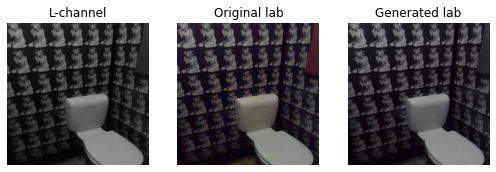

In [ ]:
# testing once before we begin
d_test_loss, g_test_loss, _, _, _ = test(generator, discriminator, test_ds, bce_loss)
test_d_losses.append(d_test_loss)
test_g_losses.append(g_test_loss)

# check how model performs on train data once before we begin
d_train_loss, g_train_loss, _, _, _ = test(generator, discriminator, train_ds, bce_loss)
train_d_losses.append(d_train_loss)
train_g_losses.append(g_train_loss)

# We train for num_epochs epochs
for epoch in range(num_epochs):

    # training (and checking in with training)
    epoch_loss_agg_d = []
    epoch_loss_agg_g = []

    for l_images, ab_images in train_ds:
        d_train_loss, g_train_loss = train_step(generator, discriminator, l_images, ab_images, bce_loss, discriminator_optimizer, generator_optimizer)
        epoch_loss_agg_d.append(d_train_loss)
        epoch_loss_agg_g.append(g_train_loss)

    # track training loss
    train_d_losses.append(tf.reduce_mean(epoch_loss_agg_d))
    train_g_losses.append(tf.reduce_mean(epoch_loss_agg_g))
    
    # testing, so we can track test loss
    d_test_loss, g_test_loss, generated_ab_img, l_img, original_ab_img = test(generator, discriminator, test_ds, bce_loss)
    test_d_losses.append(d_test_loss)
    test_g_losses.append(g_test_loss)
    
    print(f'Epoch: {epoch} :   Discriminator test loss: {d_test_loss} ;  Generator test loss: {g_test_loss}')

    
    # Visualize L-channel, Original lab image and Generated lab image
    plot_imgs(l_img, original_ab_img, generated_ab_img)

    print('\n')

visualization(train_d_losses, train_g_losses, test_d_losses, test_g_losses)